# EfficientNet-B0 for PneumoniaMNIST
Fine-tuning a pretrained **EfficientNet-B0** on the PneumoniaMNIST binary classification dataset (Normal vs Pneumonia).
Includes full metrics: Accuracy, Precision, Recall, F1, Specificity, Sensitivity, MCC, AUC.


In [1]:
!pip install timm medmnist scikit-learn matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 6.0 MB/s eta 0:00:00


In [2]:
import os
import math
import time
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import timedelta
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchinfo import summary
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, confusion_matrix, classification_report
)
import medmnist
from medmnist import PneumoniaMNIST, INFO


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

info = INFO['pneumoniamnist']
print("Task:", info['task'])
print("Classes:", info['label'])
NUM_CLASSES = len(info['label'])
print("Num classes:", NUM_CLASSES)


Using device: cuda
Task: binary-class
Classes: {'0': 'normal', '1': 'pneumonia'}
Num classes: 2


## Data Transforms
PneumoniaMNIST images are 28×28 grayscale — upsampled to 224×224 and converted to 3-channel RGB.

In [4]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    
   
    
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])


In [5]:
BATCH_SIZE = 64

train_ds = PneumoniaMNIST(split='train', transform=train_transform, download=True)
val_ds   = PneumoniaMNIST(split='val',   transform=val_test_transform, download=True)
test_ds  = PneumoniaMNIST(split='test',  transform=val_test_transform, download=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train size : {len(train_ds)}")
print(f"Val   size : {len(val_ds)}")
print(f"Test  size : {len(test_ds)}")


100%|██████████| 4.17M/4.17M [00:01<00:00, 3.44MB/s]


Train size : 4708
Val   size : 524
Test  size : 624


## Model: EfficientNet-B0 (Pretrained)
Pretrained on ImageNet-1K. Final classifier replaced for binary output.

In [6]:
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# EfficientNet classifier: Sequential(Dropout, Linear(1280, 1000))
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)

model = model.to(device)

dummy = torch.zeros(2, 3, 224, 224).to(device)
with torch.no_grad():
    out = model(dummy)
print("Output shape:", out.shape)  # [2, 2]

summary(model, input_size=(1, 3, 224, 224),
        col_names=("input_size", "output_size", "num_params"), depth=3)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 179MB/s]


Output shape: torch.Size([2, 2])


Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #
EfficientNet                                            [1, 3, 224, 224]          [1, 2]                    --
├─Sequential: 1-1                                       [1, 3, 224, 224]          [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]          [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         [1, 32, 112, 112]         64
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 32, 112, 112]         [1, 16, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 32, 112, 112]         [1, 16, 112, 112]       

In [7]:
def custom_metrics(y_pred, y_true, loss):
    y_prob         = torch.softmax(y_pred, dim=1)
    y_pred_classes = torch.argmax(y_prob, dim=1)

    y_true_np = y_true.cpu().numpy()
    y_pred_np = y_pred_classes.cpu().numpy()
    y_prob_np = y_prob.cpu().numpy()

    accuracy  = accuracy_score(y_true_np, y_pred_np)
    precision = precision_score(y_true_np, y_pred_np, average='weighted', zero_division=0)
    recall    = recall_score(y_true_np, y_pred_np, average='weighted', zero_division=0)
    f1        = f1_score(y_true_np, y_pred_np, average='weighted', zero_division=0)

    cm = confusion_matrix(y_true_np, y_pred_np)
    num_cls = cm.shape[0]
    specificities, sensitivities = [], []
    for i in range(num_cls):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - tp - fn - fp
        specificities.append(tn / (tn + fp) if (tn + fp) > 0 else 0.0)
        sensitivities.append(tp / (tp + fn) if (tp + fn) > 0 else 0.0)
    specificity = float(np.mean(specificities))
    sensitivity = float(np.mean(sensitivities))

    mcc = matthews_corrcoef(y_true_np, y_pred_np)

    auc_scores = []
    for cls_i in range(num_cls):
        bin_true = (y_true_np == cls_i).astype(np.float32)
        try:
            auc_scores.append(roc_auc_score(bin_true, y_prob_np[:, cls_i]))
        except ValueError:
            auc_scores.append(0.0)
    auc_avg = float(np.mean(auc_scores))

    return {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }


## Training Setup
- **Loss**: CrossEntropyLoss with label smoothing 0.1
- **Optimizer**: AdamW, weight decay 1e-2
- **Scheduler**: Cosine annealing with linear warmup
- **Gradient clipping**: max norm 1.0

In [8]:
num_epochs    = 25
initial_lr    = 3e-4
warmup_epochs = 3

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=1e-2)

def lr_lambda(epoch):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    progress = (epoch - warmup_epochs) / max(1, num_epochs - warmup_epochs)
    return 0.5 * (1.0 + math.cos(math.pi * progress))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)


In [9]:
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]

train_metrics_history = {m: [] for m in metric_names}
val_metrics_history   = {m: [] for m in metric_names}

total_training_time   = 0.0
total_validation_time = 0.0
best_val_acc          = 0.0

for epoch in range(num_epochs):

    # ── Train ────────────────────────────────────────────────────
    model.train()
    t0         = time.time()
    total_loss = 0.0
    all_preds  = []
    all_tgts   = []

    for data, targets in tqdm(train_loader, desc=f"Train [{epoch+1}/{num_epochs}]"):
        data    = data.to(device)
        targets = targets.squeeze(1).long().to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss    = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        all_preds.extend(outputs.detach().cpu().numpy())
        all_tgts.extend(targets.detach().cpu().numpy())

    total_training_time += time.time() - t0

    train_metrics = custom_metrics(
        torch.tensor(np.array(all_preds)),
        torch.tensor(np.array(all_tgts)),
        total_loss / len(train_loader)
    )
    for m in metric_names:
        train_metrics_history[m].append(train_metrics[m])
    print(f"[Train] Ep {epoch+1:2d} | " + " | ".join(f"{k}: {v:.4f}" for k, v in train_metrics.items()))

    # ── Validate ─────────────────────────────────────────────────
    model.eval()
    t0         = time.time()
    total_loss = 0.0
    all_preds  = []
    all_tgts   = []

    with torch.no_grad():
        for data, targets in tqdm(val_loader, desc="Validate"):
            data    = data.to(device)
            targets = targets.squeeze(1).long().to(device)
            outputs = model(data)
            total_loss += criterion(outputs, targets).item()
            all_preds.extend(outputs.detach().cpu().numpy())
            all_tgts.extend(targets.detach().cpu().numpy())

    total_validation_time += time.time() - t0

    val_metrics = custom_metrics(
        torch.tensor(np.array(all_preds)),
        torch.tensor(np.array(all_tgts)),
        total_loss / len(val_loader)
    )
    for m in metric_names:
        val_metrics_history[m].append(val_metrics[m])
    print(f"[Val]   Ep {epoch+1:2d} | " + " | ".join(f"{k}: {v:.4f}" for k, v in val_metrics.items()))

    if val_metrics['accuracy'] > best_val_acc:
        best_val_acc = val_metrics['accuracy']
        torch.save(model.state_dict(), '/kaggle/working/best_efficientnetb0_pneumonia.pth')
        print(f"  ✓ Best model saved  (val_acc={best_val_acc:.4f})")

    scheduler.step()
    print(f"  LR = {scheduler.get_last_lr()[0]:.2e}\n")

print(f"Total Training Time  : {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")
print(f"Avg Train Time/Epoch : {str(timedelta(seconds=total_training_time / num_epochs))}")
print(f"Avg Val   Time/Epoch : {str(timedelta(seconds=total_validation_time / num_epochs))}")


Train [1/25]: 100%|██████████| 74/74 [00:19<00:00,  3.85it/s]


[Train] Ep  1 | loss: 0.3665 | accuracy: 0.9019 | precision: 0.9019 | recall: 0.9019 | f1_score: 0.9019 | specificity: 0.8718 | sensitivity: 0.8718 | mcc: 0.7436 | auc: 0.9569


Validate: 100%|██████████| 9/9 [00:00<00:00, 11.30it/s]


[Val]   Ep  1 | loss: 0.3583 | accuracy: 0.9141 | precision: 0.9277 | recall: 0.9141 | f1_score: 0.9169 | specificity: 0.9276 | sensitivity: 0.9276 | mcc: 0.8015 | auc: 0.9827
  ✓ Best model saved  (val_acc=0.9141)
  LR = 2.00e-04



Train [2/25]: 100%|██████████| 74/74 [00:18<00:00,  4.02it/s]


[Train] Ep  2 | loss: 0.2589 | accuracy: 0.9681 | precision: 0.9680 | recall: 0.9681 | f1_score: 0.9681 | specificity: 0.9557 | sensitivity: 0.9557 | mcc: 0.9164 | auc: 0.9933


Validate: 100%|██████████| 9/9 [00:00<00:00, 11.84it/s]


[Val]   Ep  2 | loss: 0.3063 | accuracy: 0.9504 | precision: 0.9575 | recall: 0.9504 | f1_score: 0.9516 | specificity: 0.9642 | sensitivity: 0.9642 | mcc: 0.8831 | auc: 0.9941
  ✓ Best model saved  (val_acc=0.9504)
  LR = 3.00e-04



Train [3/25]: 100%|██████████| 74/74 [00:18<00:00,  4.02it/s]


[Train] Ep  3 | loss: 0.2310 | accuracy: 0.9822 | precision: 0.9821 | recall: 0.9822 | f1_score: 0.9821 | specificity: 0.9762 | sensitivity: 0.9762 | mcc: 0.9533 | auc: 0.9984


Validate: 100%|██████████| 9/9 [00:00<00:00, 12.06it/s]


[Val]   Ep  3 | loss: 0.3491 | accuracy: 0.9313 | precision: 0.9446 | recall: 0.9313 | f1_score: 0.9336 | specificity: 0.9513 | sensitivity: 0.9513 | mcc: 0.8445 | auc: 0.9820
  LR = 3.00e-04



Train [4/25]: 100%|██████████| 74/74 [00:18<00:00,  4.03it/s]


[Train] Ep  4 | loss: 0.2244 | accuracy: 0.9877 | precision: 0.9877 | recall: 0.9877 | f1_score: 0.9877 | specificity: 0.9839 | sensitivity: 0.9839 | mcc: 0.9678 | auc: 0.9988


Validate: 100%|██████████| 9/9 [00:00<00:00, 11.98it/s]


[Val]   Ep  4 | loss: 0.2610 | accuracy: 0.9618 | precision: 0.9623 | recall: 0.9618 | f1_score: 0.9620 | specificity: 0.9549 | sensitivity: 0.9549 | mcc: 0.9014 | auc: 0.9921
  ✓ Best model saved  (val_acc=0.9618)
  LR = 2.98e-04



Train [5/25]: 100%|██████████| 74/74 [00:18<00:00,  4.02it/s]


[Train] Ep  5 | loss: 0.2181 | accuracy: 0.9915 | precision: 0.9915 | recall: 0.9915 | f1_score: 0.9915 | specificity: 0.9873 | sensitivity: 0.9873 | mcc: 0.9778 | auc: 0.9989


Validate: 100%|██████████| 9/9 [00:00<00:00, 10.14it/s]


[Val]   Ep  5 | loss: 0.2771 | accuracy: 0.9695 | precision: 0.9721 | recall: 0.9695 | f1_score: 0.9699 | specificity: 0.9770 | sensitivity: 0.9770 | mcc: 0.9249 | auc: 0.9928
  ✓ Best model saved  (val_acc=0.9695)
  LR = 2.94e-04



Train [6/25]: 100%|██████████| 74/74 [00:18<00:00,  4.03it/s]


[Train] Ep  6 | loss: 0.2113 | accuracy: 0.9949 | precision: 0.9949 | recall: 0.9949 | f1_score: 0.9949 | specificity: 0.9925 | sensitivity: 0.9925 | mcc: 0.9867 | auc: 0.9997


Validate: 100%|██████████| 9/9 [00:00<00:00, 11.48it/s]


[Val]   Ep  6 | loss: 0.2936 | accuracy: 0.9580 | precision: 0.9589 | recall: 0.9580 | f1_score: 0.9583 | specificity: 0.9524 | sensitivity: 0.9524 | mcc: 0.8922 | auc: 0.9887
  LR = 2.86e-04



Train [7/25]: 100%|██████████| 74/74 [00:18<00:00,  4.01it/s]


[Train] Ep  7 | loss: 0.2090 | accuracy: 0.9951 | precision: 0.9951 | recall: 0.9951 | f1_score: 0.9951 | specificity: 0.9940 | sensitivity: 0.9940 | mcc: 0.9872 | auc: 0.9998


Validate: 100%|██████████| 9/9 [00:00<00:00, 12.01it/s]


[Val]   Ep  7 | loss: 0.2637 | accuracy: 0.9618 | precision: 0.9636 | recall: 0.9618 | f1_score: 0.9623 | specificity: 0.9622 | sensitivity: 0.9622 | mcc: 0.9036 | auc: 0.9875
  LR = 2.76e-04



Train [8/25]: 100%|██████████| 74/74 [00:18<00:00,  4.02it/s]


[Train] Ep  8 | loss: 0.2067 | accuracy: 0.9962 | precision: 0.9962 | recall: 0.9962 | f1_score: 0.9962 | specificity: 0.9953 | sensitivity: 0.9953 | mcc: 0.9900 | auc: 0.9999


Validate: 100%|██████████| 9/9 [00:00<00:00, 11.42it/s]


[Val]   Ep  8 | loss: 0.2601 | accuracy: 0.9714 | precision: 0.9727 | recall: 0.9714 | f1_score: 0.9717 | specificity: 0.9735 | sensitivity: 0.9735 | mcc: 0.9277 | auc: 0.9945
  ✓ Best model saved  (val_acc=0.9714)
  LR = 2.63e-04



Train [9/25]: 100%|██████████| 74/74 [00:18<00:00,  4.03it/s]


[Train] Ep  9 | loss: 0.2051 | accuracy: 0.9970 | precision: 0.9970 | recall: 0.9970 | f1_score: 0.9970 | specificity: 0.9956 | sensitivity: 0.9956 | mcc: 0.9922 | auc: 0.9999


Validate: 100%|██████████| 9/9 [00:00<00:00, 11.38it/s]


[Val]   Ep  9 | loss: 0.2850 | accuracy: 0.9695 | precision: 0.9710 | recall: 0.9695 | f1_score: 0.9698 | specificity: 0.9722 | sensitivity: 0.9722 | mcc: 0.9232 | auc: 0.9923
  LR = 2.48e-04



Train [10/25]: 100%|██████████| 74/74 [00:18<00:00,  4.02it/s]


[Train] Ep 10 | loss: 0.2026 | accuracy: 0.9977 | precision: 0.9977 | recall: 0.9977 | f1_score: 0.9977 | specificity: 0.9968 | sensitivity: 0.9968 | mcc: 0.9939 | auc: 1.0000


Validate: 100%|██████████| 9/9 [00:00<00:00, 11.79it/s]


[Val]   Ep 10 | loss: 0.2773 | accuracy: 0.9695 | precision: 0.9710 | recall: 0.9695 | f1_score: 0.9698 | specificity: 0.9722 | sensitivity: 0.9722 | mcc: 0.9232 | auc: 0.9950
  LR = 2.31e-04



Train [11/25]: 100%|██████████| 74/74 [00:18<00:00,  4.02it/s]


[Train] Ep 11 | loss: 0.2006 | accuracy: 0.9996 | precision: 0.9996 | recall: 0.9996 | f1_score: 0.9996 | specificity: 0.9992 | sensitivity: 0.9992 | mcc: 0.9989 | auc: 1.0000


Validate: 100%|██████████| 9/9 [00:00<00:00, 11.66it/s]


[Val]   Ep 11 | loss: 0.2772 | accuracy: 0.9618 | precision: 0.9647 | recall: 0.9618 | f1_score: 0.9624 | specificity: 0.9670 | sensitivity: 0.9670 | mcc: 0.9056 | auc: 0.9936
  LR = 2.12e-04



Train [12/25]: 100%|██████████| 74/74 [00:18<00:00,  4.02it/s]


[Train] Ep 12 | loss: 0.2020 | accuracy: 0.9981 | precision: 0.9981 | recall: 0.9981 | f1_score: 0.9981 | specificity: 0.9971 | sensitivity: 0.9971 | mcc: 0.9950 | auc: 1.0000


Validate: 100%|██████████| 9/9 [00:00<00:00, 11.59it/s]


[Val]   Ep 12 | loss: 0.2604 | accuracy: 0.9656 | precision: 0.9655 | recall: 0.9656 | f1_score: 0.9653 | specificity: 0.9454 | sensitivity: 0.9454 | mcc: 0.9092 | auc: 0.9802
  LR = 1.92e-04



Train [13/25]: 100%|██████████| 74/74 [00:18<00:00,  4.02it/s]


[Train] Ep 13 | loss: 0.2018 | accuracy: 0.9992 | precision: 0.9992 | recall: 0.9992 | f1_score: 0.9992 | specificity: 0.9986 | sensitivity: 0.9986 | mcc: 0.9978 | auc: 1.0000


Validate: 100%|██████████| 9/9 [00:00<00:00, 11.13it/s]


[Val]   Ep 13 | loss: 0.2622 | accuracy: 0.9714 | precision: 0.9723 | recall: 0.9714 | f1_score: 0.9716 | specificity: 0.9710 | sensitivity: 0.9710 | mcc: 0.9270 | auc: 0.9962
  LR = 1.71e-04



Train [14/25]: 100%|██████████| 74/74 [00:18<00:00,  4.02it/s]


[Train] Ep 14 | loss: 0.2010 | accuracy: 0.9992 | precision: 0.9992 | recall: 0.9992 | f1_score: 0.9992 | specificity: 0.9994 | sensitivity: 0.9994 | mcc: 0.9978 | auc: 1.0000


Validate: 100%|██████████| 9/9 [00:00<00:00, 11.63it/s]


[Val]   Ep 14 | loss: 0.2649 | accuracy: 0.9714 | precision: 0.9717 | recall: 0.9714 | f1_score: 0.9715 | specificity: 0.9662 | sensitivity: 0.9662 | mcc: 0.9258 | auc: 0.9950
  LR = 1.50e-04



Train [15/25]: 100%|██████████| 74/74 [00:18<00:00,  4.02it/s]


[Train] Ep 15 | loss: 0.2001 | accuracy: 0.9996 | precision: 0.9996 | recall: 0.9996 | f1_score: 0.9996 | specificity: 0.9994 | sensitivity: 0.9994 | mcc: 0.9989 | auc: 1.0000


Validate: 100%|██████████| 9/9 [00:00<00:00, 11.07it/s]


[Val]   Ep 15 | loss: 0.2717 | accuracy: 0.9676 | precision: 0.9694 | recall: 0.9676 | f1_score: 0.9680 | specificity: 0.9709 | sensitivity: 0.9709 | mcc: 0.9187 | auc: 0.9954
  LR = 1.29e-04



Train [16/25]: 100%|██████████| 74/74 [00:18<00:00,  4.02it/s]


[Train] Ep 16 | loss: 0.1997 | accuracy: 0.9998 | precision: 0.9998 | recall: 0.9998 | f1_score: 0.9998 | specificity: 0.9996 | sensitivity: 0.9996 | mcc: 0.9994 | auc: 1.0000


Validate: 100%|██████████| 9/9 [00:00<00:00, 11.57it/s]


[Val]   Ep 16 | loss: 0.2732 | accuracy: 0.9656 | precision: 0.9668 | recall: 0.9656 | f1_score: 0.9660 | specificity: 0.9648 | sensitivity: 0.9648 | mcc: 0.9126 | auc: 0.9934
  LR = 1.08e-04



Train [17/25]: 100%|██████████| 74/74 [00:18<00:00,  4.02it/s]


[Train] Ep 17 | loss: 0.2000 | accuracy: 0.9996 | precision: 0.9996 | recall: 0.9996 | f1_score: 0.9996 | specificity: 0.9992 | sensitivity: 0.9992 | mcc: 0.9989 | auc: 1.0000


Validate: 100%|██████████| 9/9 [00:00<00:00, 11.36it/s]


[Val]   Ep 17 | loss: 0.2734 | accuracy: 0.9695 | precision: 0.9706 | recall: 0.9695 | f1_score: 0.9697 | specificity: 0.9698 | sensitivity: 0.9698 | mcc: 0.9224 | auc: 0.9963
  LR = 8.77e-05



Train [18/25]: 100%|██████████| 74/74 [00:18<00:00,  4.02it/s]


[Train] Ep 18 | loss: 0.2001 | accuracy: 0.9998 | precision: 0.9998 | recall: 0.9998 | f1_score: 0.9998 | specificity: 0.9999 | sensitivity: 0.9999 | mcc: 0.9994 | auc: 1.0000


Validate: 100%|██████████| 9/9 [00:00<00:00, 10.63it/s]


[Val]   Ep 18 | loss: 0.2790 | accuracy: 0.9714 | precision: 0.9731 | recall: 0.9714 | f1_score: 0.9717 | specificity: 0.9759 | sensitivity: 0.9759 | mcc: 0.9284 | auc: 0.9949
  LR = 6.89e-05



Train [19/25]: 100%|██████████| 74/74 [00:18<00:00,  4.02it/s]


[Train] Ep 19 | loss: 0.1997 | accuracy: 0.9998 | precision: 0.9998 | recall: 0.9998 | f1_score: 0.9998 | specificity: 0.9996 | sensitivity: 0.9996 | mcc: 0.9994 | auc: 1.0000


Validate: 100%|██████████| 9/9 [00:00<00:00, 11.29it/s]


[Val]   Ep 19 | loss: 0.2800 | accuracy: 0.9676 | precision: 0.9694 | recall: 0.9676 | f1_score: 0.9680 | specificity: 0.9709 | sensitivity: 0.9709 | mcc: 0.9187 | auc: 0.9934
  LR = 5.18e-05



Train [20/25]: 100%|██████████| 74/74 [00:18<00:00,  4.01it/s]


[Train] Ep 20 | loss: 0.1999 | accuracy: 0.9996 | precision: 0.9996 | recall: 0.9996 | f1_score: 0.9996 | specificity: 0.9994 | sensitivity: 0.9994 | mcc: 0.9989 | auc: 1.0000


Validate: 100%|██████████| 9/9 [00:00<00:00, 11.52it/s]


[Val]   Ep 20 | loss: 0.2789 | accuracy: 0.9714 | precision: 0.9727 | recall: 0.9714 | f1_score: 0.9717 | specificity: 0.9735 | sensitivity: 0.9735 | mcc: 0.9277 | auc: 0.9950
  LR = 3.66e-05



Train [21/25]: 100%|██████████| 74/74 [00:18<00:00,  4.02it/s]


[Train] Ep 21 | loss: 0.2000 | accuracy: 0.9994 | precision: 0.9994 | recall: 0.9994 | f1_score: 0.9994 | specificity: 0.9990 | sensitivity: 0.9990 | mcc: 0.9983 | auc: 1.0000


Validate: 100%|██████████| 9/9 [00:00<00:00, 11.16it/s]


[Val]   Ep 21 | loss: 0.2787 | accuracy: 0.9656 | precision: 0.9673 | recall: 0.9656 | f1_score: 0.9660 | specificity: 0.9672 | sensitivity: 0.9672 | mcc: 0.9134 | auc: 0.9950
  LR = 2.38e-05



Train [22/25]: 100%|██████████| 74/74 [00:18<00:00,  4.02it/s]


[Train] Ep 22 | loss: 0.1994 | accuracy: 0.9998 | precision: 0.9998 | recall: 0.9998 | f1_score: 0.9998 | specificity: 0.9996 | sensitivity: 0.9996 | mcc: 0.9994 | auc: 1.0000


Validate: 100%|██████████| 9/9 [00:00<00:00, 11.42it/s]


[Val]   Ep 22 | loss: 0.2751 | accuracy: 0.9656 | precision: 0.9668 | recall: 0.9656 | f1_score: 0.9660 | specificity: 0.9648 | sensitivity: 0.9648 | mcc: 0.9126 | auc: 0.9948
  LR = 1.36e-05



Train [23/25]: 100%|██████████| 74/74 [00:18<00:00,  4.01it/s]


[Train] Ep 23 | loss: 0.1993 | accuracy: 1.0000 | precision: 1.0000 | recall: 1.0000 | f1_score: 1.0000 | specificity: 1.0000 | sensitivity: 1.0000 | mcc: 1.0000 | auc: 1.0000


Validate: 100%|██████████| 9/9 [00:00<00:00, 11.19it/s]


[Val]   Ep 23 | loss: 0.2738 | accuracy: 0.9676 | precision: 0.9685 | recall: 0.9676 | f1_score: 0.9678 | specificity: 0.9661 | sensitivity: 0.9661 | mcc: 0.9171 | auc: 0.9951
  LR = 6.08e-06



Train [24/25]: 100%|██████████| 74/74 [00:18<00:00,  4.02it/s]


[Train] Ep 24 | loss: 0.1992 | accuracy: 1.0000 | precision: 1.0000 | recall: 1.0000 | f1_score: 1.0000 | specificity: 1.0000 | sensitivity: 1.0000 | mcc: 1.0000 | auc: 1.0000


Validate: 100%|██████████| 9/9 [00:00<00:00, 11.96it/s]


[Val]   Ep 24 | loss: 0.2786 | accuracy: 0.9676 | precision: 0.9689 | recall: 0.9676 | f1_score: 0.9679 | specificity: 0.9685 | sensitivity: 0.9685 | mcc: 0.9179 | auc: 0.9948
  LR = 1.53e-06



Train [25/25]: 100%|██████████| 74/74 [00:18<00:00,  4.02it/s]


[Train] Ep 25 | loss: 0.1994 | accuracy: 1.0000 | precision: 1.0000 | recall: 1.0000 | f1_score: 1.0000 | specificity: 1.0000 | sensitivity: 1.0000 | mcc: 1.0000 | auc: 1.0000


Validate: 100%|██████████| 9/9 [00:00<00:00, 11.60it/s]

[Val]   Ep 25 | loss: 0.2762 | accuracy: 0.9695 | precision: 0.9706 | recall: 0.9695 | f1_score: 0.9697 | specificity: 0.9698 | sensitivity: 0.9698 | mcc: 0.9224 | auc: 0.9947
  LR = 0.00e+00

Total Training Time  : 0:07:41.005840
Total Validation Time: 0:00:19.784323
Avg Train Time/Epoch : 0:00:18.440234
Avg Val   Time/Epoch : 0:00:00.791373


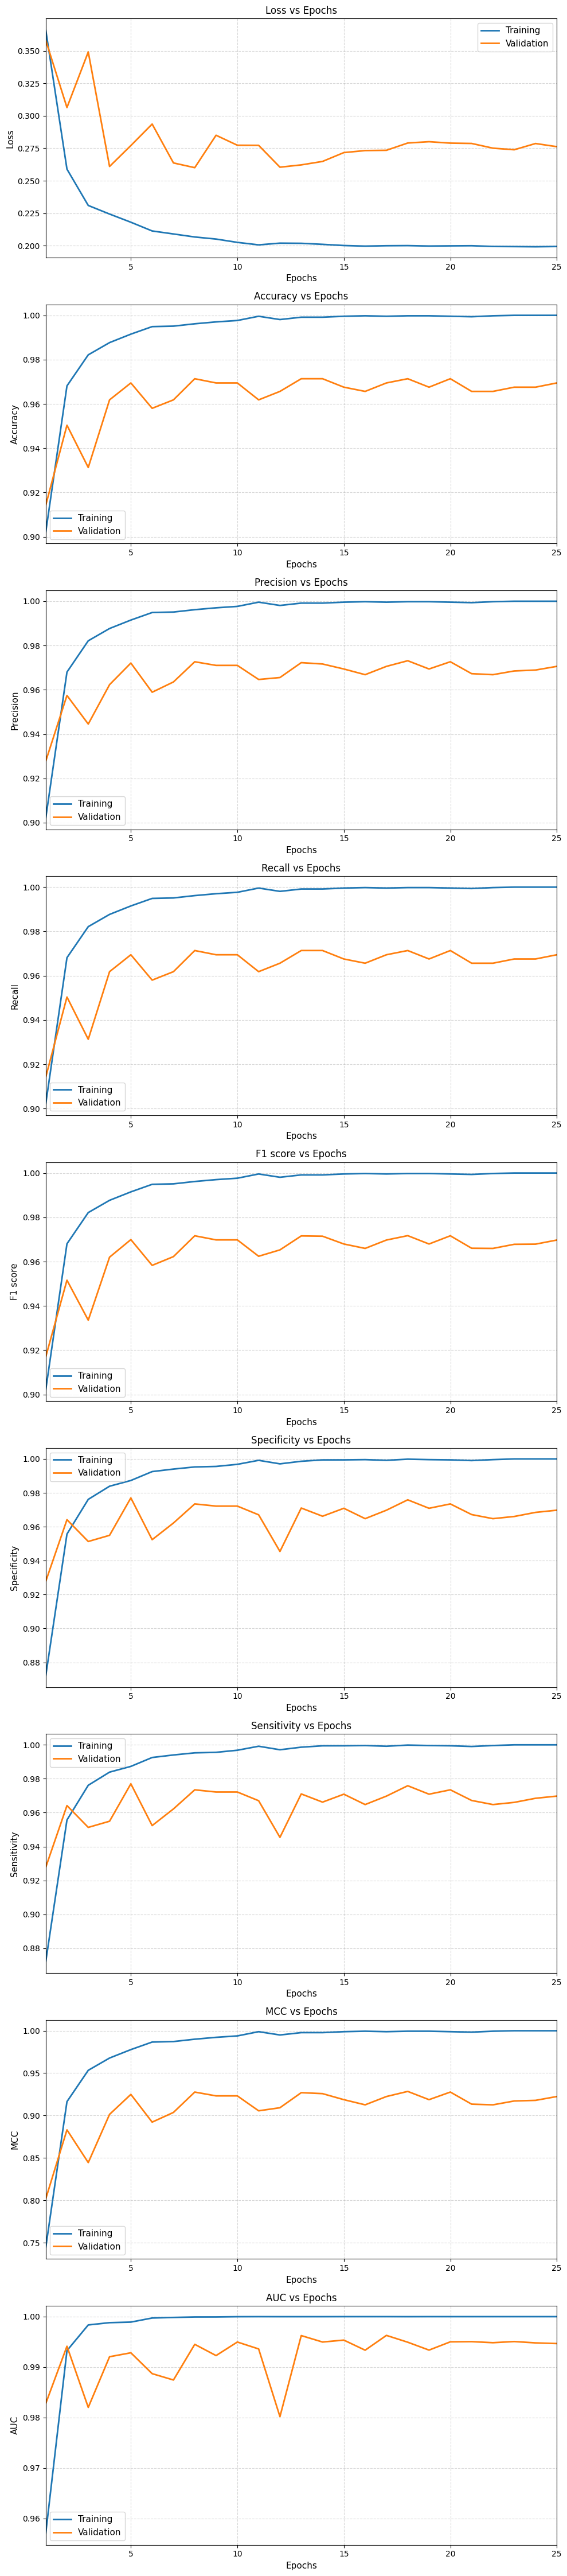

In [10]:
def plot_metrics(train_history, val_history, metric_names):
    num_ep = len(train_history[metric_names[0]])
    fig, axes = plt.subplots(len(metric_names), 1, figsize=(10, 5 * len(metric_names)))
    rng = range(1, num_ep + 1)
    for ax, name in zip(axes, metric_names):
        ax.plot(rng, train_history[name], label="Training",   linewidth=2)
        ax.plot(rng, val_history[name],   label="Validation", linewidth=2)
        ax.legend(fontsize=11)
        ax.set_xlabel("Epochs", fontsize=11)
        label = name.upper() if name in ("auc", "mcc") else name.replace("_", " ").capitalize()
        ax.set_ylabel(label, fontsize=11)
        ax.set_title(f"{label} vs Epochs", fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_ep)
    plt.tight_layout()
    plt.savefig('/kaggle/working/efficientnetb0_training_metrics.png', dpi=150)
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)


## Test Evaluation
Loads the best checkpoint and evaluates on the test set.

In [11]:
model.load_state_dict(torch.load('/kaggle/working/best_efficientnetb0_pneumonia.pth', map_location=device))
model.eval()

total_loss = 0.0
all_preds  = []
all_tgts   = []

with torch.no_grad():
    for data, targets in tqdm(test_loader, desc="Testing"):
        data    = data.to(device)
        targets = targets.squeeze(1).long().to(device)
        outputs = model(data)
        total_loss += criterion(outputs, targets).item()
        all_preds.extend(outputs.detach().cpu().numpy())
        all_tgts.extend(targets.detach().cpu().numpy())

all_preds = np.array(all_preds)
all_tgts  = np.array(all_tgts)

test_metrics = custom_metrics(
    torch.tensor(all_preds),
    torch.tensor(all_tgts),
    total_loss / len(test_loader)
)

print("=" * 40)
print("         TEST RESULTS")
print("=" * 40)
for k, v in test_metrics.items():
    print(f"  {k:14s}: {v:.4f}")
print("=" * 40)


Testing: 100%|██████████| 10/10 [00:00<00:00, 11.32it/s]

         TEST RESULTS
  loss          : 0.4033
  accuracy      : 0.9006
  precision     : 0.9120
  recall        : 0.9006
  f1_score      : 0.8971
  specificity   : 0.8692
  sensitivity   : 0.8692
  mcc           : 0.7945
  auc           : 0.9485


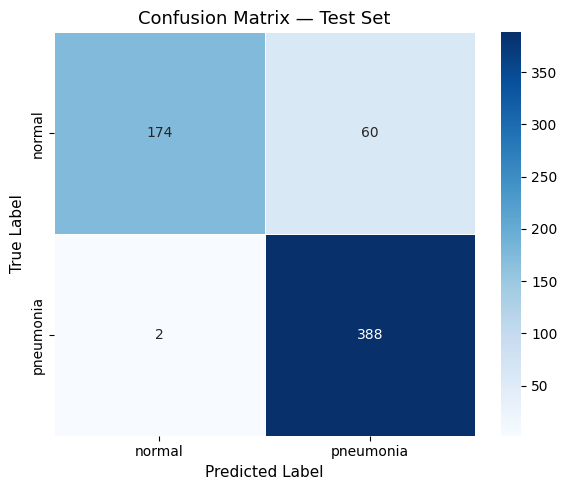


Classification Report:
              precision    recall  f1-score   support

      normal       0.99      0.74      0.85       234
   pneumonia       0.87      0.99      0.93       390

    accuracy                           0.90       624
   macro avg       0.93      0.87      0.89       624
weighted avg       0.91      0.90      0.90       624



In [12]:
CLASS_NAMES = list(info['label'].values())

y_pred_cls = np.argmax(all_preds, axis=1)
cm = confusion_matrix(all_tgts, y_pred_cls)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, linewidths=0.5)
plt.title('Confusion Matrix — Test Set', fontsize=13)
plt.ylabel('True Label', fontsize=11)
plt.xlabel('Predicted Label', fontsize=11)
plt.tight_layout()
plt.savefig('/kaggle/working/efficientnetb0_confusion_matrix.png', dpi=150)
plt.show()

print("\nClassification Report:")
print(classification_report(all_tgts, y_pred_cls, target_names=CLASS_NAMES))


## Sample Predictions
Visualise 18 test images with predicted vs true labels.

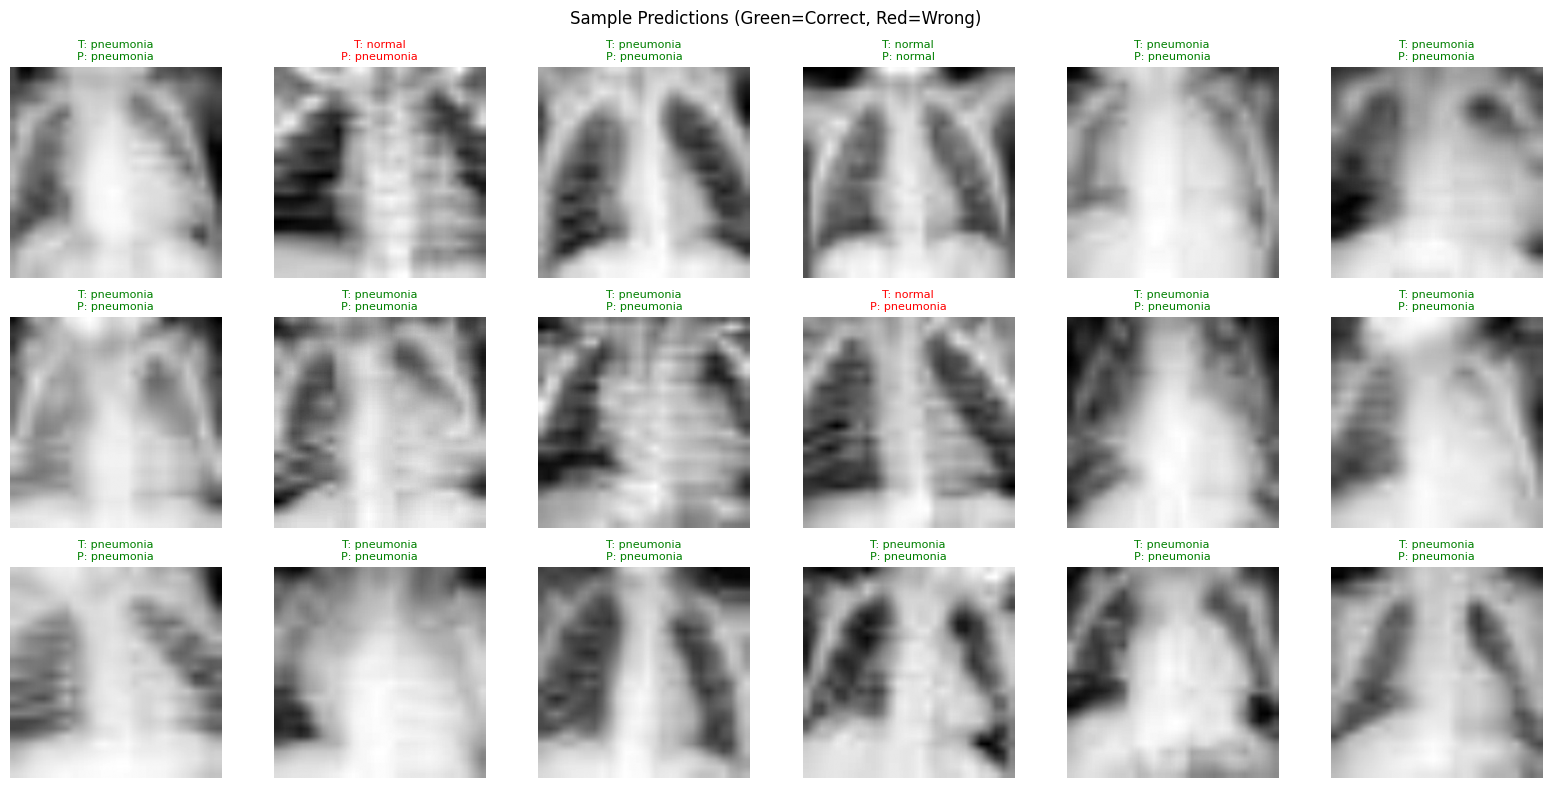

In [13]:
model.eval()
images_shown = 0
fig, axes = plt.subplots(3, 6, figsize=(16, 8))
axes = axes.flatten()

IMAGENET_MEAN_T = torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
IMAGENET_STD_T  = torch.tensor(IMAGENET_STD).view(3, 1, 1)

with torch.no_grad():
    for data, targets in test_loader:
        data_dev = data.to(device)
        targets  = targets.squeeze(1).long()
        outputs  = model(data_dev)
        preds    = torch.argmax(torch.softmax(outputs, dim=1), dim=1).cpu()

        for i in range(len(data)):
            if images_shown >= 18:
                break
            img = data[i].cpu() * IMAGENET_STD_T + IMAGENET_MEAN_T
            img = img.permute(1, 2, 0).numpy().clip(0, 1)
            axes[images_shown].imshow(img[:, :, 0], cmap='gray')
            true_lbl = CLASS_NAMES[targets[i].item()]
            pred_lbl = CLASS_NAMES[preds[i].item()]
            color    = 'green' if targets[i] == preds[i] else 'red'
            axes[images_shown].set_title(f"T: {true_lbl}\nP: {pred_lbl}", fontsize=8, color=color)
            axes[images_shown].axis('off')
            images_shown += 1
        if images_shown >= 18:
            break

plt.suptitle('Sample Predictions (Green=Correct, Red=Wrong)', fontsize=12)
plt.tight_layout()
plt.savefig('/kaggle/working/efficientnetb0_sample_preds.png', dpi=150)
plt.show()
